# Bi-Persistence Clustering on the Diabetes Dataset

In 1979, [Reaven, Miller &
Alto](https://link.springer.com/article/10.1007/BF00423145) analysed the
difference between chemical and overt diabetes in 145 non-obese adults.
Previously, they had found a "horseshoe" relation between plasma glucose and
insulin response levels, confirmed by later studies. However, the interpretation
of this relationship remained unclear. It could be interpreted as the natural
progression of diabetes or as different underlying causes for the disease. In
their 1979 work, they attempted to quantify the relationship to gain insight
into the pattern.

This notebook demonstrates how BPSCAN can be used to the low-density branches
that form the "horseshoe" relation. HDBSCAN* and FLASC are also evaluated on the
dataset as an example. All algorithms are manually tuned so their clusters best
match the groups visible in a UMAP projection of the data.

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import pandas as pd

from umap import UMAP
from flasc import FLASC
from hdbscan import HDBSCAN
from biperscan import BPSCAN
from sklearn.preprocessing import StandardScaler

from lib.plotting import *
from matplotlib.colors import Normalize, to_rgb, ListedColormap
from matplotlib.lines import Line2D

tab10 = configure_matplotlib()

First, we load the data and compute a UMAP embedding. UMAP is tuned to emphasize
the data's global structure. Specifically, we use a fairly high number of
neighbours and low repulsion strength.

In [5]:
df = pd.read_csv("./data/diabetes/chemical_and_overt_diabetes.csv").iloc[:, 1:-1]
X = StandardScaler().fit_transform(df)

In [6]:
# X2 = UMAP(
#     n_neighbors=80, n_epochs=300, repulsion_strength=0.002, min_dist=0.1
# ).fit_transform(X)
# np.save("./data/diabetes/umap_embedding.npy", X2)

In [7]:
X2 = np.load("./data/diabetes/umap_embedding.npy")

Now we plot the data colouring points by the area under their glucose curve in
red and the area under their insulin area in blue. The peaks of both features
correspond to the branches:

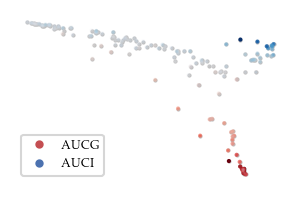

In [8]:
glucose_norm = Normalize(df[" glucose area"].min(), df[" glucose area"].max())
glucose_colors = [
    (*to_rgb(plt.cm.Reds(glucose_norm(x))), glucose_norm(x))
    for x in df[" glucose area"]
]
insulin_norm = Normalize(df[" insulin area"].min(), df[" insulin area"].max())
insulin_colors = [
    (*to_rgb(plt.cm.Blues(insulin_norm(x))), insulin_norm(x))
    for x in df[" insulin area"]
]

sized_fig(0.33)
plt.scatter(*X2.T, s=1, color="silver")
plt.scatter(*X2.T, s=1, c=glucose_colors)
plt.scatter(*X2.T, s=1, c=insulin_colors)
plt.legend(
    loc="lower left",
    handles=[
        Line2D([0], [0], linewidth=0, marker=".", color="r", label="AUCG"),
        Line2D([0], [0], linewidth=0, marker=".", color="b", label="AUCI"),
    ],
)
plt.axis("off")
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("images/diabetes_umap.pdf", pad_inches=0)
plt.show()

HDBSCAN struggles to detect these branches as distinct clusters. Only with the
*leaf* cluster selection method and low *min samples* values will HDBSCAN detect
small density peaks in the branches.

c:\Users\lucp10736\Micromamba\envs\work\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lucp10736\Micromamba\envs\work\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


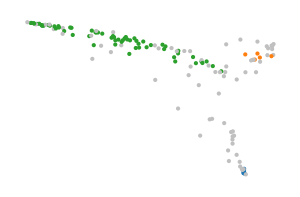

In [9]:
sized_fig(0.33)
c = HDBSCAN(min_cluster_size=5, cluster_selection_method="leaf").fit(X)
cmap = ListedColormap(["silver"] + [plt.cm.tab10.colors[i] for i in range(10)])
plt.scatter(*X2.T, c=c.labels_, s=1, cmap=cmap, vmin=-1, vmax=9)
plt.axis("off")
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("images/diabetes_hdbscan.pdf", pad_inches=0)
plt.show()

BPSCAN's labels more closely match the projected shape (though, blue and red
should be seen as a single cluster). The algorithm does require a carefully
tuned *min. samples* value.

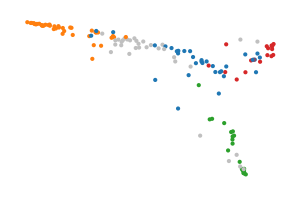

In [10]:
sized_fig(0.33)
c = BPSCAN(min_samples=5, min_cluster_size=15).fit(X)
plt.scatter(*X2.T, c=c.labels_, s=1, cmap=cmap, vmin=-1, vmax=9)
plt.axis("off")
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("images/diabetes_bpscan.pdf", pad_inches=0)
plt.show()

FLASC most accurately describes this dataset, as a single cluster with three
branches. Most of the cluster is fairly central, indicated by the blue cluster.
The other clusters indicate the branches, one of which is also very central and
could be tuned out using a persistence threshold. FLASC also requires tuning,
*min. samples* and *min. branch size* need to be set to low values to prevent
cross-branch connectivity of the least central points.

c:\Users\lucp10736\Micromamba\envs\work\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lucp10736\Micromamba\envs\work\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


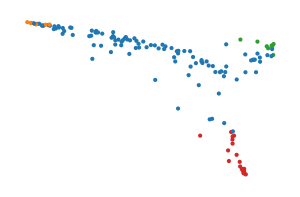

In [19]:
sized_fig(0.33)
c2 = FLASC(min_samples=5, min_branch_size=5, allow_single_cluster=True).fit(X)
plt.scatter(*X2.T, c=c2.labels_, s=1, cmap=cmap, vmin=-1, vmax=9)
plt.axis("off")
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("images/diabetes_flasc.pdf", pad_inches=0)
plt.show()

## Additional Explanatory Figures

This section creates several additional explanatory figures used to describe BPSCAN.

A plot showing Vietoris Rips complexes for merges in the centrality--distance
space (use `c.merge_hierarchy_` to find the merge ids to include in the plot).

In [20]:
merge_ids = [2, 6, 15]
m = c.merges_
merges = m.merges
minpres = m.minpres
lens_values = [merges["lens_value"][i] for i in merge_ids]
distance_values = [merges["distance_value"][i] for i in merge_ids]
parent_sides = [merges["parent_side"][i] for i in merge_ids]
child_sides = [merges["child_side"][i] for i in merge_ids]
textcoords = [ (0.25, 0.5), (0.56, 0.5), (0.865, 0.5)]

In [21]:
import networkx as nx
from scipy.spatial.distance import squareform
from scipy.sparse import coo_array


def draw_vr_complex(x, y, dists, lens, dist_t, lens_t, xlim=None, ylim=None):
    # Extract edges within thresholds
    edges = coo_array(squareform(dists <= dist_t))
    edges.eliminate_zeros()
    g = nx.Graph(edges).subgraph(np.where(lens < lens_t)[0])
    node_list = [p for c in nx.connected_components(g) if len(c) > 1 for p in c]
    g = g.subgraph(node_list)

    # List triangular faces
    faces = []
    for source in g.nodes:
        for neighbor in g.neighbors(source):
            for second_degree in g.neighbors(neighbor):
                if source in g.neighbors(second_degree):
                    faces.append((source, neighbor, second_degree))
    poly = [
        [
            (x[face[0]], y[face[0]]),
            (x[face[1]], y[face[1]]),
            (x[face[2]], y[face[2]]),
        ]
        for face in faces
    ]

    # Prepare for plotting
    ax = plt.gca()
    pos = np.column_stack((x, y))
    node_list = list(g.nodes)
    edge_list = list(g.edges)
    node_colors = lens[node_list]

    # Draw points and edges
    mask = np.ones(len(x), dtype=bool)
    mask[node_list] = False
    plt.scatter(x[mask], y[mask], c="silver", s=3, edgecolors="none", linewidths=0)
    nx.draw_networkx(
        g,
        pos=pos,
        ax=ax,
        edgelist=edge_list,
        nodelist=node_list,
        edge_color="k",
        node_color=node_colors,
        width=0.5,
        node_size=1,
        with_labels=False,
        cmap="viridis",
        vmin=0,
        vmax=1,
    )

    # Draw faces
    for face in range(len(faces)):
        p = plt.Polygon(poly[face], fc="k", alpha=0.015)
        ax.add_patch(p)

    if xlim is None:
        ax.set_aspect("equal")
        xlim = plt.xlim()
        ylim = plt.ylim()
    else:
        plt.xlim(xlim)
        plt.ylim(ylim)

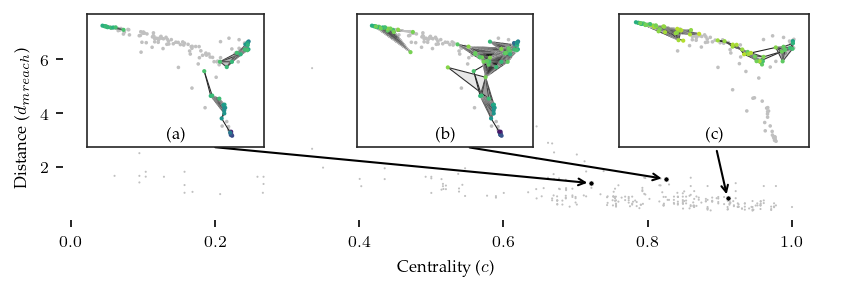

In [22]:
fig = sized_fig(1, aspect=0.33)

# Draw minpres edges
plt.scatter(
    minpres["lens_value"],
    minpres["distance_value"],
    c="silver",
    s=1,
    edgecolors="none",
    linewidths=0,
)

# Draw merges
plt.scatter(
    lens_values, distance_values, c="black", s=6, edgecolors="white", linewidths=0.3
)

# Draw arrows
for i, txt in enumerate(merge_ids):
    plt.annotate(
        "",
        (lens_values[i], distance_values[i]),
        textcoords[i],
        textcoords=fig.transFigure,
        va="center",
        ha="center",
        arrowprops=dict(arrowstyle="->", color="black"),
    )

# Set outer axis labels
plt.ylabel("Distance ($d_{mreach}$)")
plt.xlabel("Centrality ($c$)")

# Draw VR complexes as overlapping subplots
labels = ["(a)", "(b)", "(c)"]
for i, txt in enumerate(merge_ids):
    row = i + 1
    plt.sca(fig.add_subplot(3, 3, (row, row+3), label=i))
    draw_vr_complex(
        *X2.T, c.distances_, c.lens_values_, distance_values[i], lens_values[i]
    )
    plt.gca().spines["top"].set_visible(True)
    plt.gca().spines["right"].set_visible(True)
    plt.gca().spines["bottom"].set_visible(True)
    plt.gca().spines["left"].set_visible(True)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(labels[i], labelpad=-10)

plt.subplots_adjust(0.07, 0.23, 1, 0.99)
plt.savefig("images/diabetes_vr_complex.pdf", pad_inches=0)
plt.show()

..

The minimal presentation edges as curves in the centrality--distance plane.
Three curves are highlighted, corresponding to the low(est)-centrality points in
the branches.

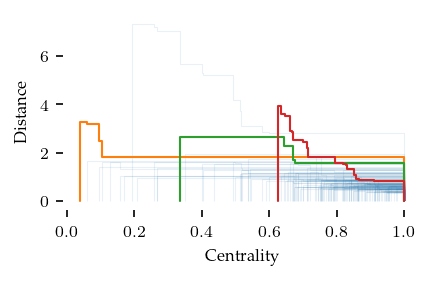

In [23]:
sized_fig()
minpres = c.minimal_presentation_
minpres.plot_persistence_areas(
    view_type="value", line_kws=dict(alpha=0.1, linestyle="-", linewidths=0.5)
)
plt.xlabel('Centrality')
plt.ylabel('Distance')
curves = minpres.compute_value_death_curves()
for i, p in enumerate([1, 13, 31]):
    plt.plot(*curves[p].T, color=f"C{i+1}", linewidth=1)
plt.subplots_adjust(0.13, 0.23, 1, 1)
plt.savefig("images/diabetes_minpres_values.pdf", pad_inches=0)
plt.show()

The minimum presentation as a graph. Points are coloured by centrality grade and
edges are coloured by distance grade. The three root points are indicated by
crosses.

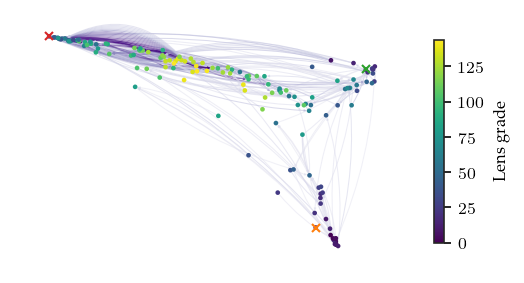

In [24]:
sized_fig()
pos = minpres.plot_network(
    layout={i: (c[0], c[1]) for i, c in enumerate(X2)},
    labels=False,
    node_kws=dict(node_size=5, edgecolors="none", linewidths=0),
    line_kws=dict(width=0.5, arrowsize=2, alpha=0.5, edge_vmin=-1000, edge_vmax=4000),
)
for i, p in enumerate([1, 13, 31]):
    plt.plot(*X2[c._row_to_point[p]].T, "x", color=f"C{i+1}", markersize=4)
plt.subplots_adjust(0, 0, 1.2, 1)
plt.savefig("images/diabetes_minpres_network.pdf", pad_inches=0)
plt.show()

The detected merges on the distance--centrality plane:

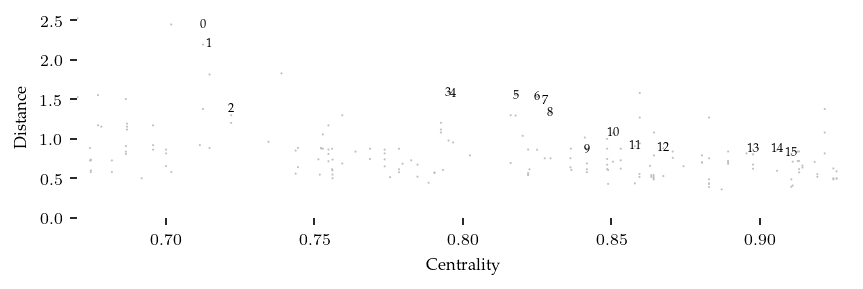

In [25]:
sized_fig(1, 0.33)
m.plot_persistence_areas(view_type='value')
plt.xlim(0.67, 0.93)
plt.xlabel('Centrality')
plt.ylabel('Distance')
plt.subplots_adjust(0.08, 0.22, 1.02, 0.97)
plt.savefig("images/diabetes_merge_hierarchy_values.pdf", pad_inches=0)
plt.show()

The connected components that become connected in each merge.

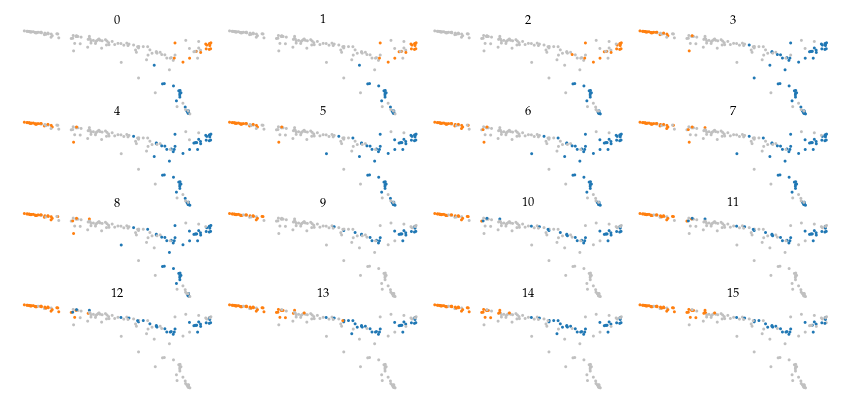

In [26]:
sized_fig(1, 0.618/4*3)
m.plot_merges(*X2.T, s=2, arrowsize=8, linewidth=0.5)
plt.subplots_adjust(0, 0, 1, 0.96, 0, 0)
plt.savefig("images/diabetes_merge_hierarchy_points.pdf", pad_inches=0)
plt.show()

Bi-grade traces of the simplified merges indicating which merges were combined into one.

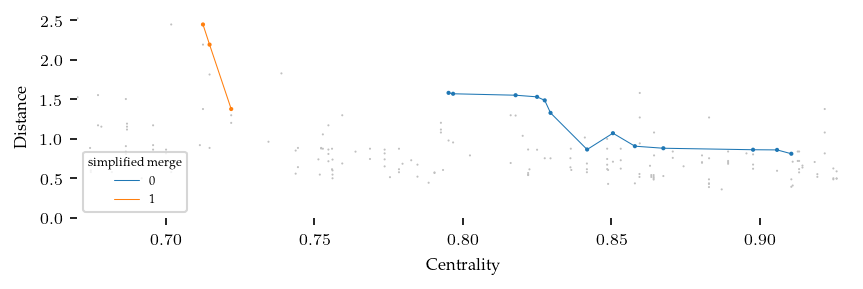

In [27]:
sized_fig(1, 0.33)
c.simplified_merges_.plot_persistence_areas(view_type='value')
plt.xlim(0.67, 0.93)
plt.xlabel('Centrality')
plt.ylabel('Distance')
plt.subplots_adjust(0.08, 0.22, 1.02, 0.97)
plt.savefig("images/diabetes_simplified_hierarchy_values.pdf", pad_inches=0)
plt.show()

The connected components being connected by the simplified merges.

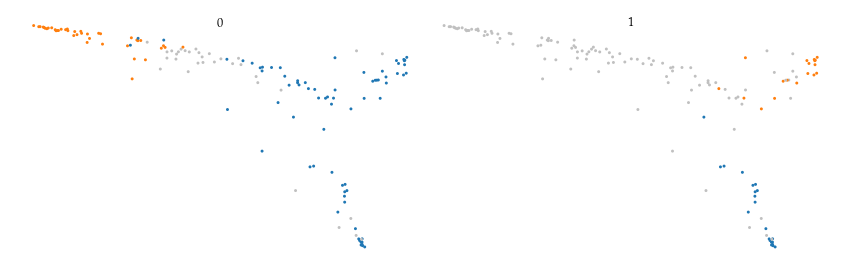

In [28]:
sized_fig(1, 0.618/2)
c.simplified_merges_.plot_merges(*X2.T, s=2, n_rows=1, n_cols=2)
plt.subplots_adjust(0, 0, 1, 0.96, 0, 0)
plt.savefig("images/diabetes_simplified_hierarchy_points.pdf", pad_inches=0)
plt.show()

The full linkage hierarchy in distance--centrality space and as a network.

In [18]:
h = c.linkage_hierarchy_

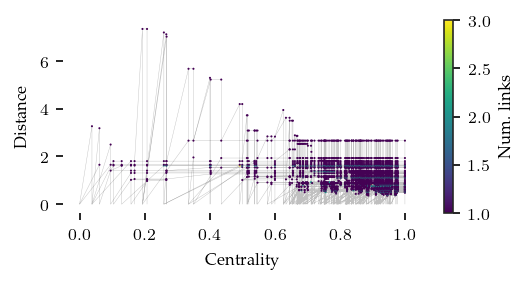

In [19]:
sized_fig()
h.plot_persistence_areas(
    view_type="value",
    node_kws=dict(s=1, edgecolors="none", linewidths=0),
    line_kws=dict(lw=0.2, color="silver"),
    labels=False,
)
plt.xlabel("Centrality")
plt.ylabel("Distance")
plt.subplots_adjust(0.13, 0.23, 1.22, 0.99)
plt.savefig('images/diabetes_linkage_hierarchy_values.pdf', pad_inches=0)
plt.show()

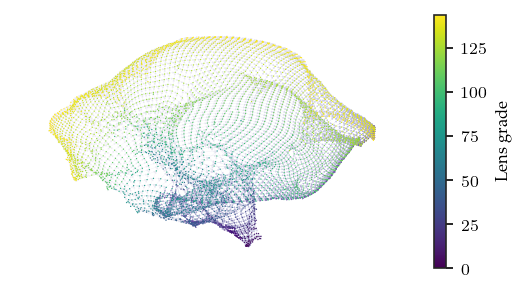

In [20]:
sized_fig()
pos = h.plot_network(
    layout="sfdp",
    node_kws=dict(node_size=0.4, edgecolors="none", linewidths=0),
    line_kws=dict(width=0.1, arrowsize=2, edge_vmin=-1000, edge_vmax=8000),
    labels=False,
)
# xs = [pos[i][0] for i in range(len(df))]
# ys = [pos[i][1] for i in range(len(df))]
# plt.scatter(xs, ys, c=c.labels_, s=1, cmap=cmap, vmin=-1, vmax=9)
plt.subplots_adjust(0, 0, 1.2, 1)
plt.savefig("images/diabetes_linkage_hierarchy_network.pdf", pad_inches=0)
plt.show()